# MNIST with colors

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import scipy.ndimage
from PIL import Image as PILImage

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image

from tensorflow.examples.tutorials.mnist import input_data


Using TensorFlow backend.


In [2]:
import keras.backend.tensorflow_backend as ktf
import tensorflow as tf
import os

def get_session(gpu_fraction=0.45):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())


# Creating colorfull MNIST data

The original MNIST dataset has only one channel which makes it easier for a GAN to tackle. Eventually though, we want to work with color images. To do this I'll show you a quick and easy way to create a custom "colorfull MNIST" dataset which can be used as input for a GAN.

The same as berfore, we start with reading the original MNIST data. For this I use a small utility function from Tensorflow. The MNIST set is later used as a base for generating our colorfull images.


In [28]:
# Read MNIST data
x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


With the MNIST images loaded we are going to map these to a 3-channel space. For this I apply a nice technique I adapted from a repository on [domain adaptation](https://github.com/davidtellez/adda_mnist64). The main idea is to blend an MNIST digit with a colorfull background. For this we use the popular "[Lenna](https://en.wikipedia.org/wiki/Lenna)" or "[Lena](https://en.wikipedia.org/wiki/Lenna)" image:

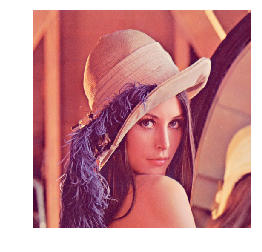

In [36]:
# Read Lena image
lena = PILImage.open('resources/lena.jpg')

plt.imshow(lena)
plt.axis('off')
plt.show()

To generate a new sample we start with taking a random crop of the Lena image. Then, for every pixel of the MNIST digit we invert the colors 

Given an MNIST image we overlay the number onto a colorfull background that we crop from a source image. The pixels that contain the number are inverted to let the number stand out.

In [37]:
def get_mnist_batch(batch_size=256, change_colors=False):
    
    # Select random batch (WxHxC)
    idx = np.random.choice(x_train.shape[0], batch_size)
    batch_raw = x_train[idx, :, :, 0].reshape((batch_size, 28, 28, 1))
    
    # Resize
    batch_resized = np.asarray([scipy.ndimage.zoom(image, (2.3, 2.3, 1), order=1) for image in batch_raw])
    
    # Extend to RGB
    batch_rgb = np.concatenate([batch_resized, batch_resized, batch_resized], axis=3)
    
    # Make binary
    batch_binary = (batch_rgb > 0.5)
    
    batch = np.zeros((batch_size, 64, 64, 3))
    
    for i in range(batch_size):
        # Take a random crop of the Lena image (background)
        x_c = np.random.randint(0, lena.size[0] - 64)
        y_c = np.random.randint(0, lena.size[1] - 64)
        image = lena.crop((x_c, y_c, x_c + 64, y_c + 64))
        image = np.asarray(image) / 255.0

        if change_colors:
            # Change color distribution
            for j in range(3):
                image[:, :, j] = (image[:, :, j] + np.random.uniform(0, 1)) / 2.0

        # Invert the colors at the location of the number
        image[batch_binary[i]] = 1 - image[batch_binary[i]]
        
        batch[i] = image
    
    # Map the whole batch to [-1, 1]
    #batch = batch / 0.5 - 1

    return batch


A set of example images is shown below:

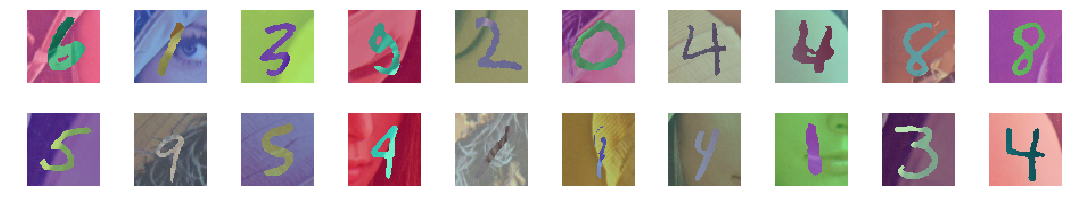

In [38]:
count = 20
examples = get_mnist_batch(count)

# Map back to normal range
#examples = (examples + 1) * 0.5

plt.figure(figsize=(15,3))
for i in range(count):
    plt.subplot(2, count // 2, i+1)
    plt.imshow(examples[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()


# Defining the discriminator

In [39]:
def discriminator():
    
    net = Sequential()
    input_shape = (64, 64, 3)
    dropout_prob = 0.4

    net.add(Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(LeakyReLU())
    
    net.add(Conv2D(128, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(512, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Flatten())
    net.add(Dense(1))
    net.add(Activation('sigmoid'))
    
    return net

In [40]:
net_discriminator = discriminator()
net_discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 256)         0         
__________

# Defining the generator

In [41]:
def generator():
    
    net = Sequential()
    dropout_prob = 0.4
    
    net.add(Dense(8*8*256, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    net.add(Reshape((8,8,256)))
    net.add(Dropout(dropout_prob))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(UpSampling2D())
    net.add(Conv2D(64, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(Conv2D(32, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(Conv2D(3, 5, padding='same'))
    net.add(Activation('sigmoid'))
    
    return net

In [42]:
net_generator = generator()
net_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
activation_9 (Activation)    (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 128)       819328    
__________

In [43]:
optim_discriminator = RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8)
model_discriminator = Sequential()
model_discriminator.add(net_discriminator)
model_discriminator.compile(loss='binary_crossentropy', optimizer=optim_discriminator, metrics=['accuracy'])

model_discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 1)                 4314753   
Total params: 4,314,753
Trainable params: 4,314,753
Non-trainable params: 0
_________________________________________________________________


In [44]:
optim_adversarial = Adam(lr=0.0001, clipvalue=1.0, decay=3e-8)
model_adversarial = Sequential()
model_adversarial.add(net_generator)

# Disable layers in discriminator
for layer in net_discriminator.layers:
    layer.trainable = False

model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])

model_adversarial.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 64, 64, 3)         3209283   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 4314753   
Total params: 7,524,036
Trainable params: 3,175,811
Non-trainable params: 4,348,225
_________________________________________________________________


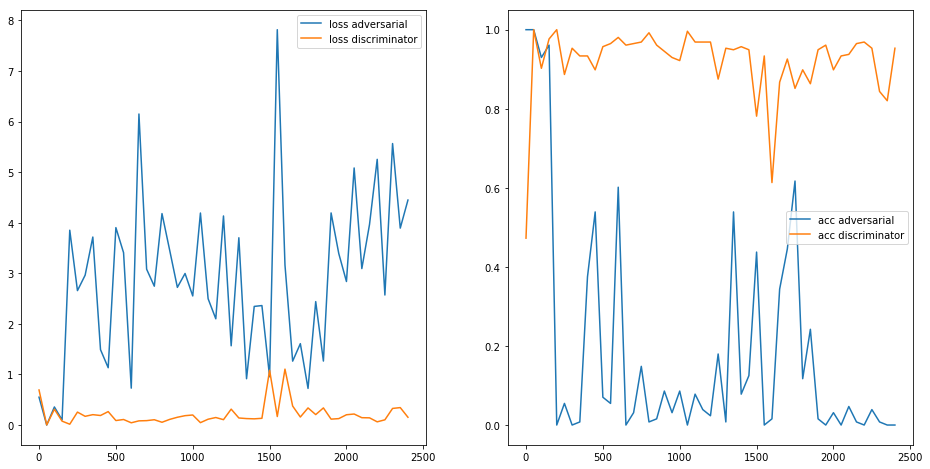

In [ ]:
batch_size = 128

vis_noise = np.random.uniform(-1.0, 1.0, size=[16, 100])

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

for i in range(0, 20001):
    
    images_train = get_mnist_batch(batch_size)
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    images_fake = net_generator.predict(noise)
    
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0 

    # Train discriminator for one batch
    d_stats = model_discriminator.train_on_batch(x, y)
    
    y = np.ones([batch_size, 1])
    # Train the generator for a number of times
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_stats = model_adversarial.train_on_batch(noise, y)
        
    if i % 50 == 0:
        plot_iteration.append(i)
        loss_adv.append(a_stats[0])
        loss_dis.append(d_stats[0])
        acc_adv.append(a_stats[1])
        acc_dis.append(d_stats[1])

        clear_output(wait=True)fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 8)

ax1.plot(plot_iteration, loss_adv, label="loss adversarial")
ax1.plot(plot_iteration, loss_dis, label="loss discriminator")
#ax1.set_ylim([0,5])
ax1.legend()

ax2.plot(plot_iteration, acc_adv, label="acc adversarial")
ax2.plot(plot_iteration, acc_dis, label="acc discriminator")
ax2.legend()

plt.show()
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax1.plot(plot_iteration, loss_adv, label="loss adversarial")
        ax1.plot(plot_iteration, loss_dis, label="loss discriminator")
        #ax1.set_ylim([0,5])
        ax1.legend()

        ax2.plot(plot_iteration, acc_adv, label="acc adversarial")
        ax2.plot(plot_iteration, acc_dis, label="acc discriminator")
        ax2.legend()

        plt.show()
    
    if (i < 1000 and i%50 == 0) or (i % 100 == 0):
        images = net_generator.predict(vis_noise)
        
        # Map back to original range
        #images = (images + 1 ) * 0.5
        
        plt.figure(figsize=(10,10))
        for im in range(images.shape[0]):
            plt.subplot(4, 4, im+1)
            image = images[im, :, :, :]
            image = np.reshape(image, [64,64,3])
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(r'output/mnist-color/{}.png'.format(i))
        plt.close('all')

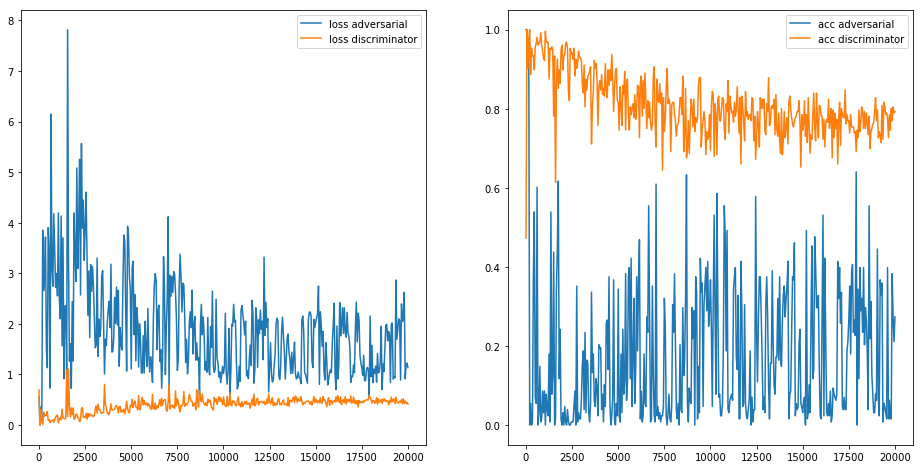

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 8)

ax1.plot(plot_iteration, loss_adv, label="loss adversarial")
ax1.plot(plot_iteration, loss_dis, label="loss discriminator")
#ax1.set_ylim([0,5])
ax1.legend()

ax2.plot(plot_iteration, acc_adv, label="acc adversarial")
ax2.plot(plot_iteration, acc_dis, label="acc discriminator")
ax2.legend()

plt.show()

In [47]:
import imageio

filenames = [r'output/mnist-color/{}.png'.format(i * 50) if i < 21 else r'output/mnist-color/{}.png'.format(i * 100) for i in range(200)]
print(filenames)
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(r'output/mnist-color/learning.gif', images, duration=0.07)

Image(url='output/mnist-color/learning.gif')  

['output/mnist-color/0.png', 'output/mnist-color/50.png', 'output/mnist-color/100.png', 'output/mnist-color/150.png', 'output/mnist-color/200.png', 'output/mnist-color/250.png', 'output/mnist-color/300.png', 'output/mnist-color/350.png', 'output/mnist-color/400.png', 'output/mnist-color/450.png', 'output/mnist-color/500.png', 'output/mnist-color/550.png', 'output/mnist-color/600.png', 'output/mnist-color/650.png', 'output/mnist-color/700.png', 'output/mnist-color/750.png', 'output/mnist-color/800.png', 'output/mnist-color/850.png', 'output/mnist-color/900.png', 'output/mnist-color/950.png', 'output/mnist-color/1000.png', 'output/mnist-color/2100.png', 'output/mnist-color/2200.png', 'output/mnist-color/2300.png', 'output/mnist-color/2400.png', 'output/mnist-color/2500.png', 'output/mnist-color/2600.png', 'output/mnist-color/2700.png', 'output/mnist-color/2800.png', 'output/mnist-color/2900.png', 'output/mnist-color/3000.png', 'output/mnist-color/3100.png', 'output/mnist-color/3200.png',

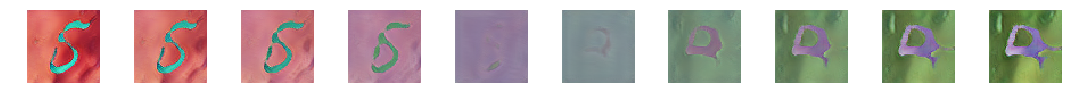

In [48]:
plt.figure(figsize=(15,4))

for i in range(10):
    noise = np.zeros([1,100]) - 1 + (i * 0.2) + 0.1 
    images = net_generator.predict(noise)
    
    image = images[0, :, :, :]
    image = np.reshape(image, [64, 64, 3])
          
    plt.subplot(1, 10, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()
    
    

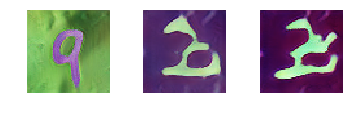

In [49]:
a = np.random.uniform(-1.0, 1.0, size=[1, 100])
b = np.random.uniform(-1.0, 1.0, size=[1, 100])

image_a = np.reshape(net_generator.predict(a)[0],  [64, 64, 3])
image_b = np.reshape(net_generator.predict(b)[0],  [64, 64, 3])
image_sum = np.reshape(net_generator.predict(b - a)[0],  [64, 64, 3])

plt.figure(figsize=(5,4))

plt.subplot(1,3,1)
plt.imshow(image_a)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(image_b)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(image_sum)
plt.axis('off')

plt.tight_layout()
plt.show()

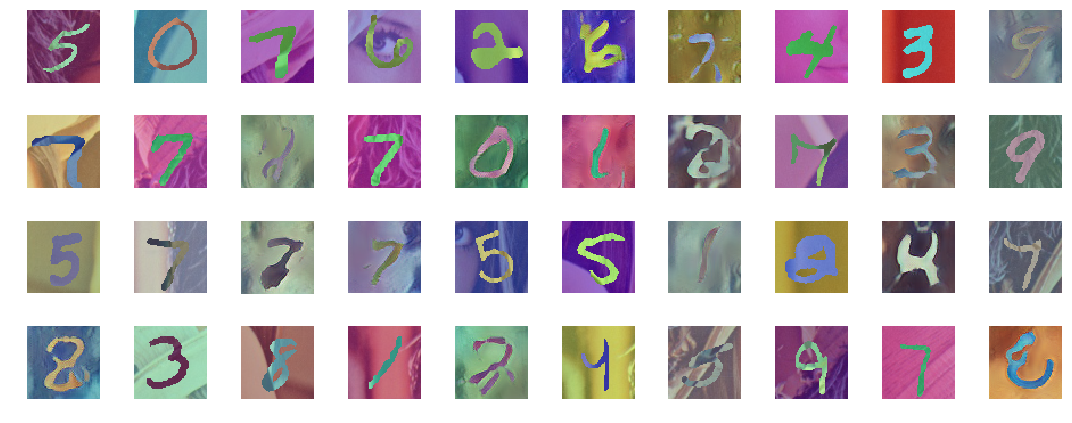

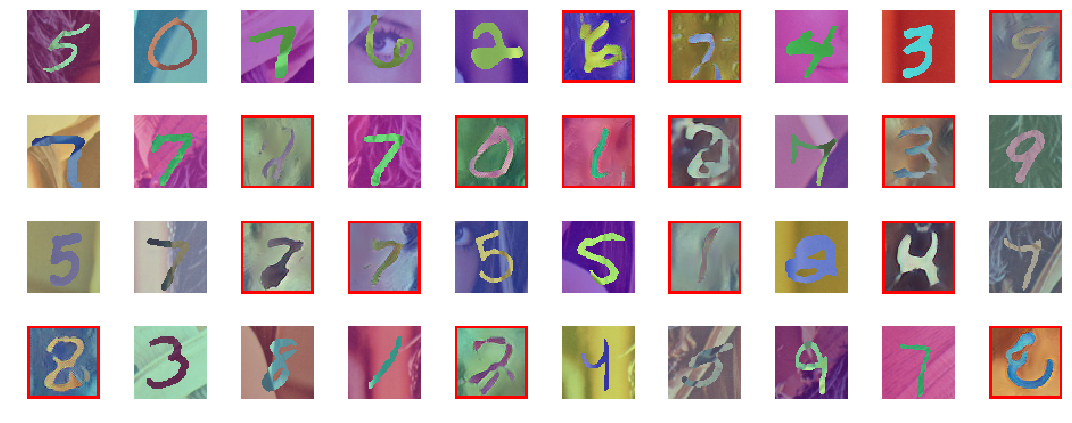

In [50]:
import matplotlib.patches as plot_patch

plt.figure(figsize=(15,6))
noise = np.random.uniform(-1.0, 1.0, size=[40, 100])
images_fake = net_generator.predict(noise)
images_real = get_mnist_batch(40)
choice_vector = np.random.uniform(0, 1, size=40)

for i in range(40):
    
    if choice_vector[i] > 0.5:
        image = images_fake[i, :, :, :]
    else:
        image = images_real[i]
    image = np.reshape(image, [64, 64, 3])

    plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15,6))

border = np.zeros((64,64,3))
border[0,:] = [255,0,0]
border[:,0] = [255,0,0]

for i in range(40):
    
    if choice_vector[i] > 0.5:
        image = images_fake[i, :, :, :]
    else:
        image = images_real[i]
    image = np.reshape(image, [64, 64, 3])
    
    ax = plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    if choice_vector[i] > 0.5:
        ax.add_patch(plot_patch.Rectangle((0,0), 63, 63, edgecolor="red", linewidth=4, fill=False))   
    plt.axis('off')

plt.tight_layout()
plt.show()

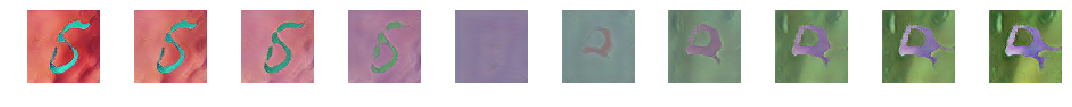

In [51]:
plt.figure(figsize=(15,4))

for i in range(10):
    noise = 0.1 * np.random.rand(1,100) - 1 + (i * 0.2) + 0.1 
    images = net_generator.predict(noise)
    
    image = images[0, :, :, :]
    image = np.reshape(image, [64, 64, 3])
          
    plt.subplot(1, 10, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()